In [1]:
from os.path import join as ospj
from copy import deepcopy

import matplotlib.pyplot as plt

In [2]:
### If using Colab, uncomment the two following lines to mount your Google Drive.

# from google.colab import drive
# drive.mount('/content/drive')


### If using Colab, change the PROJECT_ROOT to where you've uploaded the project.
### E.g. PROJECT_ROOT='/content/drive/MyDrive/TeamX/'
### You may also need to change the `data_dir`, `save_dir`, paths in the `cfgs/exercise_3/` configs.

PROJECT_ROOT='./'
# import sys
# sys.path.append(PROJECT_ROOT)

# import os
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir("/content/gdrive/MyDrive/HLCV/Assignment3")

In [3]:
# Just so that you don't have to restart the notebook with every change.
%load_ext autoreload
%autoreload 2

In Exercise 3, you will implement a convolutional neural network to perform image classification and explore methods to improve the training performance and generalization of these networks.
We will use the CIFAR-10 dataset as a benchmark for our networks, similar to the previous exercise. This dataset consists of 50000 training images of 32x32 resolution with 10 object classes, namely airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. The task is to implement a convolutional network to classify these images using the PyTorch library. The four questions are,

- Implementing a convolutional neural network, training it, and visualizing its weights (Question 1).
- Experiment with batch normalization and early stopping (Question 2).
- Data augmentation and dropout to improve generalization (Question 3).
- Implement transfer learning from an ImageNet-pretrained model (Question 4).

Before we begin, here are a few remarks regarding the codebase for this assignment.


For every experiment, you would define a config dictionary (see the dictionary in `./cfgs/exercise_3/cnn_cifar10.py`). Every config dictionary, will have the configuration for
- data (e.g batch size, shuffle, which DataModule to use, splitting)
- model (e.g which class module to use and what arguments to pass to it)
- training (e.g type of optimizer, lr_scheduler, n_epochs etc.)

The DataModules are located at  `src/data_loaders/` and they inherit from a base_data_module that handles things such as splitting the data (see `src/data_loaders/base_data_modules.py`). A sample datamodule may inherit from this class (e.g `src/data_loaders/data_modules.py`). The main concern is that datamodule initialization should get everything ready, so that one can simply get the dataloaders for train/held-out sets from it (see `get_loader` and `get_heldout_loader` in BaseDataModule). The data augmentations are also done in a preset fation. One defines the preset in `utils/transform_presets.py` and simply specifies the *preset key* in the config for datamodule.

The models are defined in `src/models/` (see for instance `src/models/cnn/model.py`). These are typical Pytorch nn.Modules that we had also seen in Assignment 2. They might additionally have extra methods such as `VisualizeFilter` in `model.py`.

The Traier glues everything together. It creates the model, sets up optimizer, lr_schduler etc. and has the option to `train()` or `evaluate()` a model over the given dataloaders. It also logs everything in `Logs/YOUR_EXP_NAME.log` and saves the checkpoints under the `Saved/YOUR_EXP_NAME/`. Please familirize yourself with the `__init__` and methods of both `trainers/base_trainer.py` and `trainers/cnn_trainer.py` before continuing with the assignment.

Lastly, for tracking different metrics (top(1/5) (train/val) accuracy or losses), we use a MetricTracker object defined in `src/utils/utils.py`. A single tracker keeps track of multiple metric keys and can `update()` their history by adding new values to a list. In the end, it can be used to return an average of a metric.


Feel free to ask questions on the forum if part of the codebase is confusing.


### Question 1: Implement Convolutional Network (10 points)

In this question, we will implement a five-layered convolutional neural network architecture as well as the loss function to train it. Refer to the comments in the code to the exact places where you need to fill in the code.

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig1_resized.png](./data/exercise-3/fig1_resized.png)

Our architecture is shown in Fig 1. It has five convolution blocks. Each block is consist of convolution, max pooling, and ReLU operation in that order. We will use 3×3 kernels in all convolutional layers. Set the padding and stride of the convolutional layers so that they maintain the spatial dimensions. Max pooling operations are done with 2×2 kernels, with a stride of 2, thereby halving the spatial resolution each time. Finally, stacking these five blocks leads to a 512 × 1 × 1 feature map. Classification is achieved by a fully connected layer. We will train convolutional neural networks on the CIFAR-10 dataset. Implement a class ConvNet to define the model described. The ConvNet takes 32 × 32 color images as inputs and has 5 hidden layers with 128, 512, 512, 512, 512 filters, and produces a 10-class classification.

a) Please implement the above network (initialization and forward pass) in class `ConvNet` in `models/cnn/model.py`. The code to train the model is already provided in the `trainers/base_trainer.py`'s train() and `trainers/cnn_trainer`'s _train_epoch(). Train the above model and report the training and validation accuracies. (5 points)

b) Implement the method `__str__` in `models/base_model.py`, which should give a string representaiton of the model. The string should show the number of `trainable` parameters for each layer. This gives us a measure of model capacity. Also at the end, it should print the total number of trainable parameters for the entire model. (2 points)

c) Implement a function `VisualizeFilter` in `models/cnn/model.py`, which visualizes the filters of the first convolution layer implemented in Q1.a. In other words, you need to show 128 filters with size 3x3 as color images (since each filter has three input channels). Stack these into 3x3 color images into one large image. You can use the `imshow` function from the `matplotlib` library to visualize the weights. See an example in Fig. 2

![Failed to load the image. Please view it yourself at ./data/exercise-3/fig2_resized.png](./data/exercise-3/fig2_resized.png)

Compare the filters before and after training. Do you see any patterns? (3 points). Please attach your output images before and after training in a cell with your submission.

In [4]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q1_experiment

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)


100%|██████████| 170498071/170498071 [00:26<00:00, 6358164.94it/s]


Extracting data/exercise-2\cifar-10-python.tar.gz to data/exercise-2
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


Number of trainable parameters in each layer: 
 3456
 128
 589824
 512
 2359296
 512
 2359296
 512
 2359296
 512
 262144
 512
 5120
 10
 Total number of parameters is 7941130


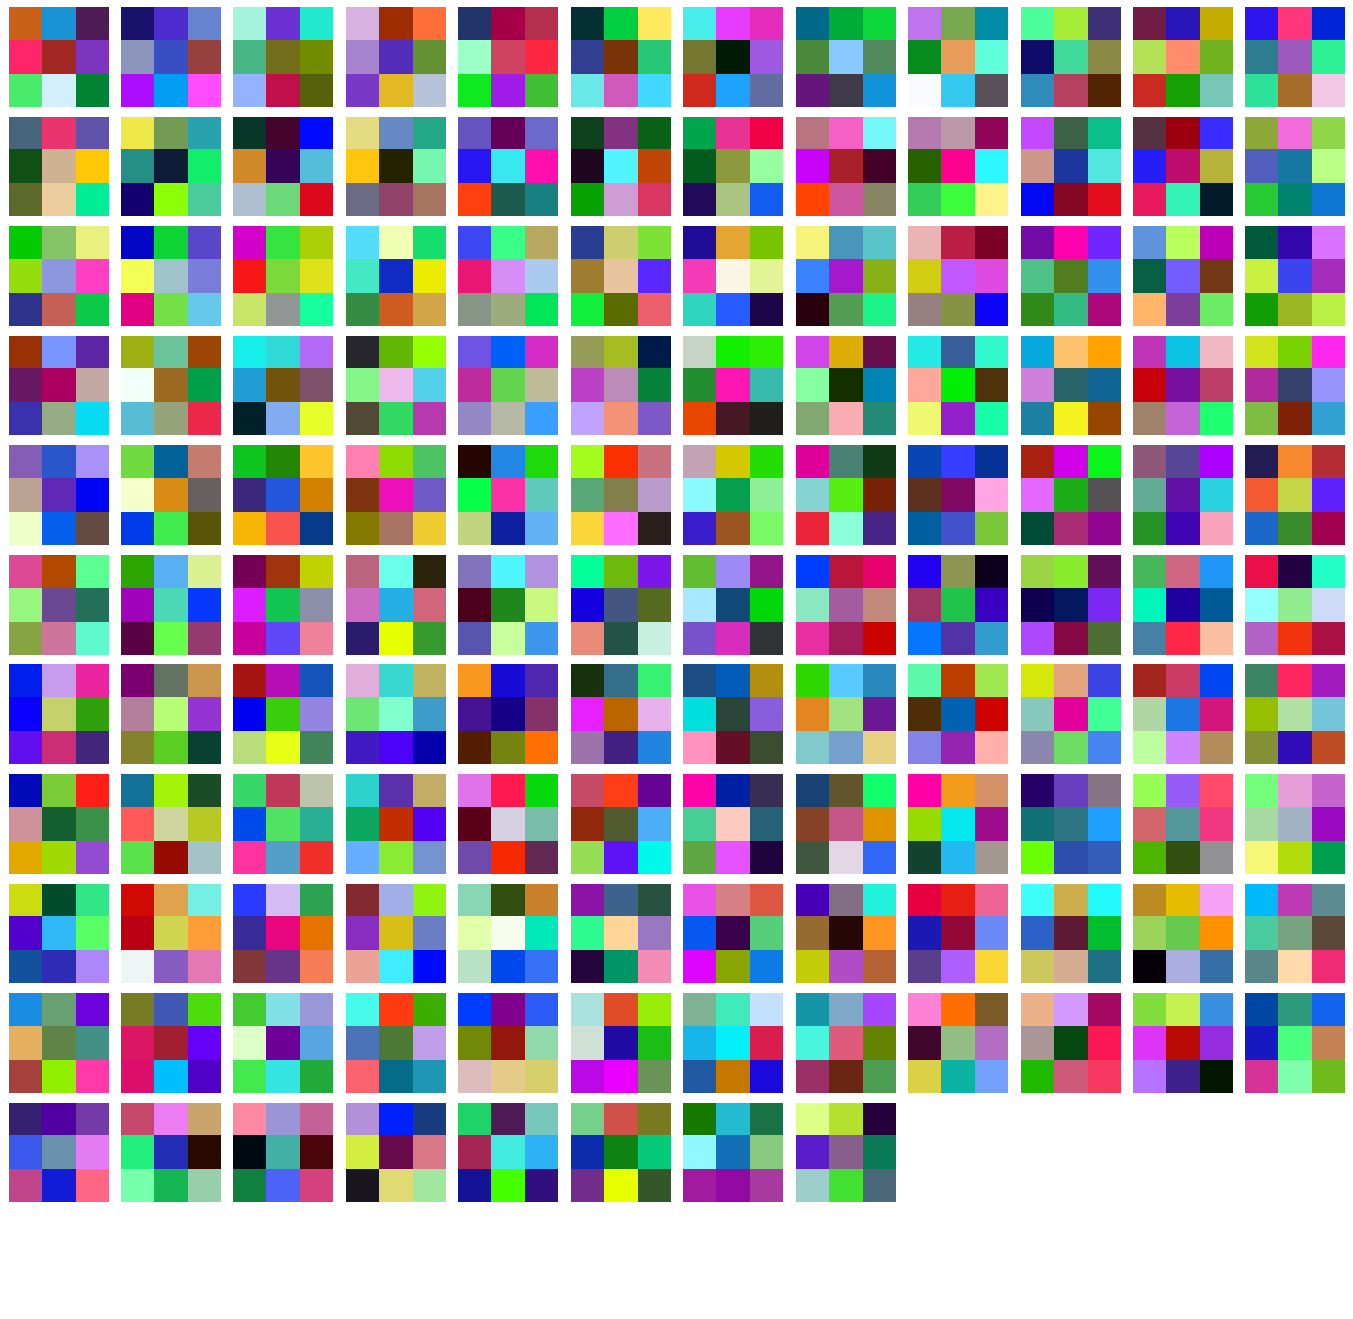

Train Epoch: 1 Loss: 1.4590: : 100% 45000/45000 [00:59<00:00, 761.26it/s] 
Eval Loss: 1.4629: : 100% 5000/5000 [00:24<00:00, 207.78it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.4402594470977783


Train Epoch: 2 Loss: 1.1175: : 100% 45000/45000 [00:42<00:00, 1067.03it/s]
Eval Loss: 1.1798: : 100% 5000/5000 [00:24<00:00, 203.35it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.4402594470977783, Current: 1.1975281572341918


Train Epoch: 3 Loss: 1.1545: : 100% 45000/45000 [00:42<00:00, 1065.87it/s]
Eval Loss: 0.8454: : 100% 5000/5000 [00:23<00:00, 217.17it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.1975281572341918, Current: 0.9094976162910462


Train Epoch: 4 Loss: 0.8655: : 100% 45000/45000 [00:40<00:00, 1120.94it/s]
Eval Loss: 0.8487: : 100% 5000/5000 [00:23<00:00, 213.01it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9094976162910462, Current: 0.8756228470802307


Train Epoch: 5 Loss: 0.7656: : 100% 45000/45000 [00:40<00:00, 1106.40it/s]
Eval Loss: 0.7246: : 100% 5000/5000 [00:22<00:00, 218.65it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.8756228470802307, Current: 0.768007972240448


Train Epoch: 6 Loss: 0.6678: : 100% 45000/45000 [00:40<00:00, 1102.79it/s]
Eval Loss: 0.5993: : 100% 5000/5000 [00:23<00:00, 212.18it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.768007972240448, Current: 0.6619263482093811


Train Epoch: 7 Loss: 0.4357: : 100% 45000/45000 [00:41<00:00, 1085.44it/s]
Eval Loss: 0.6416: : 100% 5000/5000 [00:23<00:00, 212.19it/s] 
Train Epoch: 8 Loss: 0.5194: : 100% 45000/45000 [00:39<00:00, 1153.02it/s]
Eval Loss: 0.7284: : 100% 5000/5000 [00:23<00:00, 209.08it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6619263482093811, Current: 0.6544389700889588


Train Epoch: 9 Loss: 0.4431: : 100% 45000/45000 [00:42<00:00, 1058.72it/s]
Eval Loss: 0.6339: : 100% 5000/5000 [00:23<00:00, 211.53it/s] 
Train Epoch: 10 Loss: 0.4476: : 100% 45000/45000 [00:41<00:00, 1087.46it/s]
Eval Loss: 0.6428: : 100% 5000/5000 [00:23<00:00, 211.40it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6544389700889588, Current: 0.6477363646030426


Train Epoch: 11 Loss: 0.4733: : 100% 45000/45000 [00:42<00:00, 1059.62it/s]
Eval Loss: 0.6420: : 100% 5000/5000 [00:24<00:00, 207.58it/s] 
Train Epoch: 12 Loss: 0.3054: : 100% 45000/45000 [00:39<00:00, 1135.82it/s]
Eval Loss: 0.5927: : 100% 5000/5000 [00:23<00:00, 216.79it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6477363646030426, Current: 0.6324967265129089


Train Epoch: 13 Loss: 0.2762: : 100% 45000/45000 [00:41<00:00, 1094.39it/s]
Eval Loss: 0.7174: : 100% 5000/5000 [00:22<00:00, 218.90it/s] 
Train Epoch: 14 Loss: 0.3067: : 100% 45000/45000 [00:39<00:00, 1147.66it/s]
Eval Loss: 0.7140: : 100% 5000/5000 [00:22<00:00, 220.72it/s] 
Train Epoch: 15 Loss: 0.3140: : 100% 45000/45000 [00:41<00:00, 1095.03it/s]
Eval Loss: 0.6600: : 100% 5000/5000 [00:23<00:00, 215.48it/s] 
Train Epoch: 16 Loss: 0.1342: : 100% 45000/45000 [00:39<00:00, 1133.61it/s]
Eval Loss: 0.6906: : 100% 5000/5000 [00:22<00:00, 217.53it/s] 
Train Epoch: 17 Loss: 0.1543: : 100% 45000/45000 [00:42<00:00, 1065.29it/s]
Eval Loss: 0.6122: : 100% 5000/5000 [00:22<00:00, 221.90it/s] 
Train Epoch: 18 Loss: 0.1570: : 100% 45000/45000 [00:39<00:00, 1141.01it/s]
Eval Loss: 0.8245: : 100% 5000/5000 [00:22<00:00, 223.27it/s] 
Train Epoch: 19 Loss: 0.2086: : 100% 45000/45000 [00:40<00:00, 1104.09it/s]
Eval Loss: 0.7356: : 100% 5000/5000 [00:22<00:00, 218.68it/s] 
Train Epoch: 20 Loss: 0.122

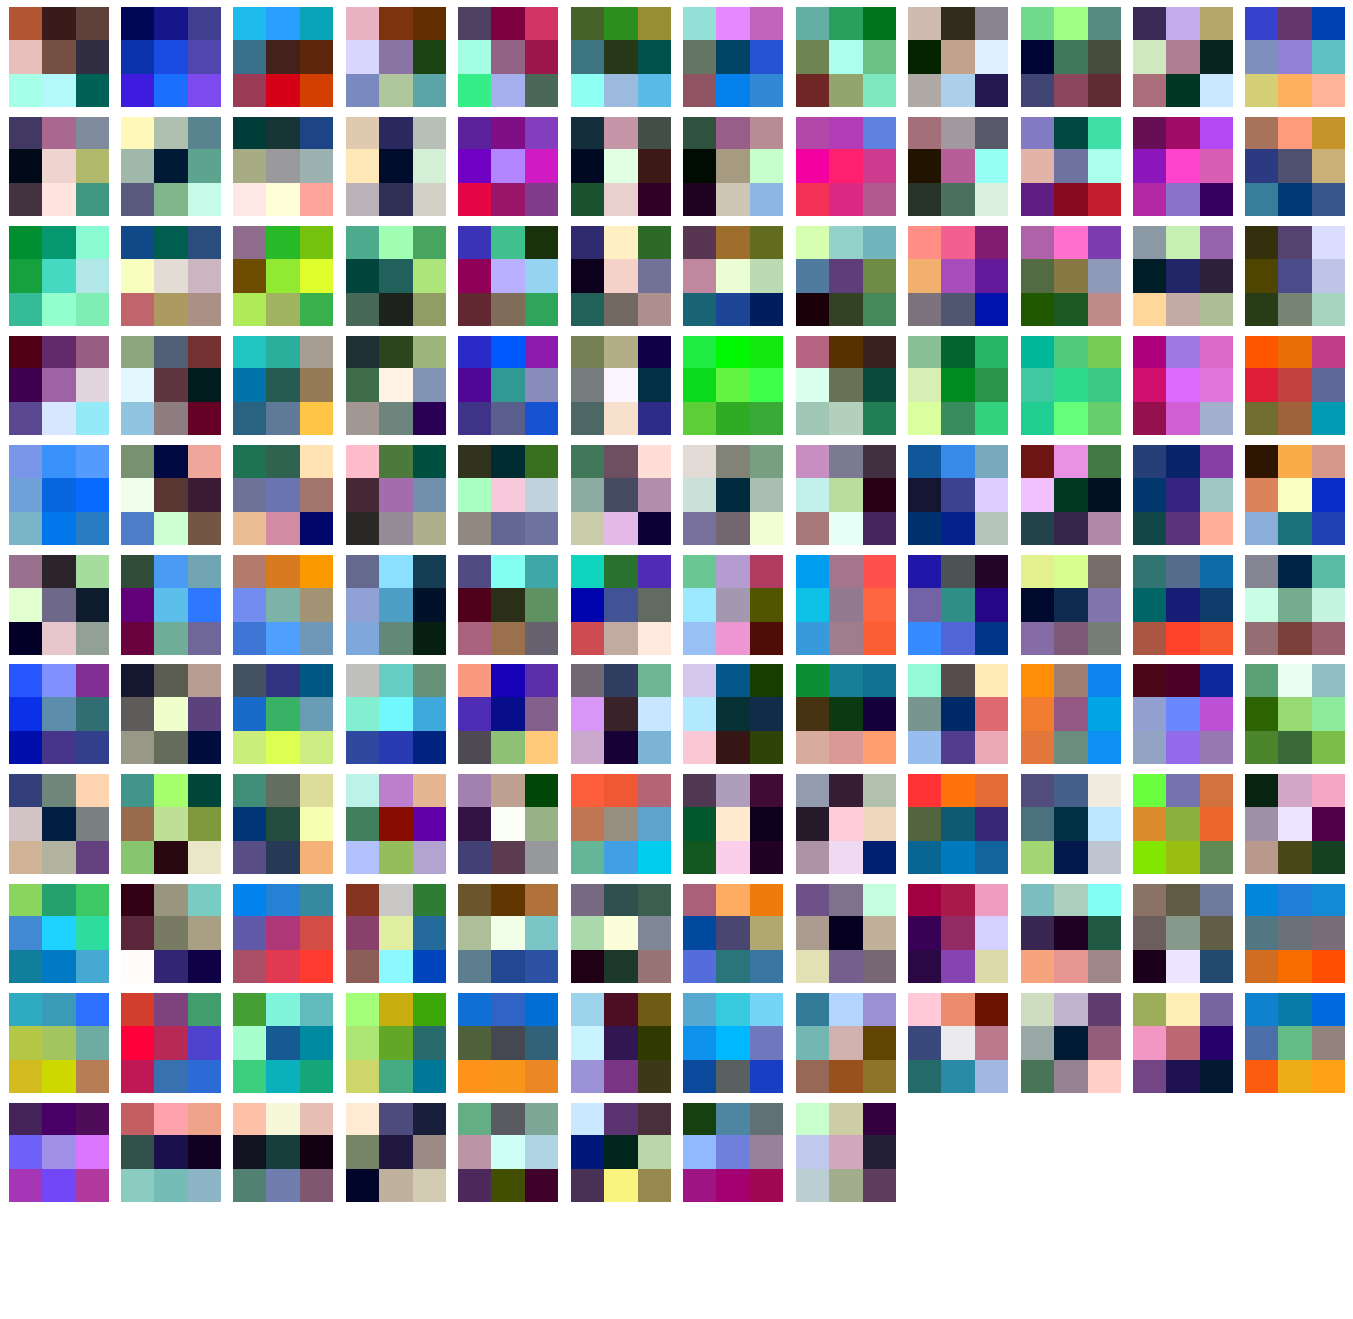

In [5]:
trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

trainer_cnn.model.VisualizeFilter()
train_loss_list, eval_loss_list  = trainer_cnn.train()
trainer_cnn.model.VisualizeFilter()

In [6]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN/last_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

Eval Loss: 0.9576: : 100% 10000/10000 [00:19<00:00, 509.33it/s]

{'loss': 0.9038638174533844, 'top1': 0.7806000000000002, 'top5': 0.9813000000000001}


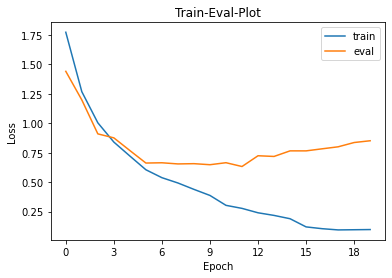

In [11]:
from matplotlib.ticker import MaxNLocator
plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
# Ensure the x-axis values are integers
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.legend()
plt.show()

#### Wirte your report for Q1 in this cell.

Q1-a: Training and validation loses are printed after each epoch on the corresponding cells. The final model, after 10 epochs of training, provides the following results on validation data: Loss: 0.6939, Top1: 0.7665, Top5: 0.9839

Q1-b: The __str__ function is implemented and is called before start of the trainig process. So the result of this function is visible after corresponding cell. For instance, we can mention the printed result of this function for part 'a' here again: <br>
|| Number of trainable parameters in each layer: <br>
    3456 <br>
    128 <br>
    589824 <br>
    512 <br>
    2359296 <br>
    512 <br>
    2359296 <br>
    512 <br>
    2359296 <br>
    512 <br>
    262144 <br>
    512 <br>
    5120 <br>
    10 <br>
    Total number of parameters is 7941130 ||

Q1-c:  
In the first pictures, filter's content is random, as we expected from our implementation and random initialization, and no structure can be seen in the filters.  
In the second picture, some structures can be seen in filters after trainig. Filters at the first layer, are learned to detect some simple and high-level structures. One can see that filters are formed similar to edge-detector filters, corner-detector filters, color-detector filters (shade and intensity), and intensity-detector filters (based on specific texture or color).

<br>

### Question 2: Improve training of Convolutional Networks (15 points)

a) Batch normalization is a widely used operation in neural networks, which will increase the speed of convergence and reach higher performance. You can read the paper “Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift” for more theoretical details.
In practice, these operations are implemented in most toolboxes, such as PyTorch and TensorFlow. Add batch normalization in the model of Q1.a (You can use PyTorch's implementation). Please keep other hyperparameters the same, but only add batch normalization. The ConvNet with batch normalization still uses the same class with Q1.a but different arguments. Check the code for details. In each block, the computations should be in the order of **[convolution -> batch normalization -> pooling -> ReLU]**. Compare the loss curves and accuracy using batch normalization to its counterpart in Q1.a. (5 points)

In order to run this experiment, please create a new config dictionary in `cnn_cifar10.py` under the name `q2a_normalization_experiment` (Hint: most of it should be similar to Q1's config). Don't forget to assign the config a new name, so that it doesn't overwrite previous experiments. Similar to the above cells, import the config and run the experiment.

You can also add extra code to `base_trainer.py` or `cnn_trainer.py` so that they return extra information after the training is finished. For example, recall that in assignment 2's `models/twolayernet/model.py` we had a train method that would return the history of loss values, and then in the notebook the history was plotted with matplotlib. Feel free to make adjustments that let you better understand what's happening. This also applies to next questions. Right now the code only uses tensorboard and wandb for plotting (if enabled in config).

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2a_config = cnn_cifar10.q2a_normalization_experiment

datamodule_class = q2a_config['datamodule']
data_args = q2a_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}


In [ ]:
trainer_class = q2a_config['trainer_module']
trainer_cnn = trainer_class(
    config = q2a_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()

Warning! Log file ./Logs\CIFAR10_CNN_q2a.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_q2a already exists!Existing checkpoints will be overwritten!
Number of trainable parameters in each layer: 
 3456
 128
 128
 128
 589824
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 262144
 512
 5120
 10
 Total number of parameters is 7945482


Train Epoch: 1 Loss: 1.1580: : 100% 45000/45000 [00:50<00:00, 898.93it/s] 
Eval Loss: 1.4519: : 100% 5000/5000 [00:17<00:00, 283.75it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.4303299713134765


Train Epoch: 2 Loss: 1.1195: : 100% 45000/45000 [00:44<00:00, 1003.16it/s]
Eval Loss: 1.2140: : 100% 5000/5000 [00:17<00:00, 291.12it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.4303299713134765, Current: 1.1655022096633911


Train Epoch: 3 Loss: 0.8518: : 100% 45000/45000 [00:43<00:00, 1023.54it/s]
Eval Loss: 0.8933: : 100% 5000/5000 [00:16<00:00, 298.39it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.1655022096633911, Current: 0.9015238881111145


Train Epoch: 4 Loss: 0.8050: : 100% 45000/45000 [00:43<00:00, 1039.80it/s]
Eval Loss: 0.8434: : 100% 5000/5000 [00:16<00:00, 297.71it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9015238881111145, Current: 0.8861186122894287


Train Epoch: 5 Loss: 0.7406: : 100% 45000/45000 [00:43<00:00, 1027.17it/s]
Eval Loss: 0.7322: : 100% 5000/5000 [00:16<00:00, 294.73it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.8861186122894287, Current: 0.7936564469337464


Train Epoch: 6 Loss: 0.6320: : 100% 45000/45000 [00:43<00:00, 1030.82it/s]
Eval Loss: 0.6914: : 100% 5000/5000 [00:16<00:00, 296.99it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7936564469337464, Current: 0.7344376397132873


Train Epoch: 7 Loss: 0.6022: : 100% 45000/45000 [00:43<00:00, 1039.84it/s]
Eval Loss: 0.6752: : 100% 5000/5000 [00:16<00:00, 297.03it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7344376397132873, Current: 0.6821269059181213


Train Epoch: 8 Loss: 0.4344: : 100% 45000/45000 [00:43<00:00, 1039.41it/s]
Eval Loss: 0.7227: : 100% 5000/5000 [00:16<00:00, 297.97it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6821269059181213, Current: 0.6656900715827941


Train Epoch: 9 Loss: 0.4062: : 100% 45000/45000 [00:43<00:00, 1038.62it/s]
Eval Loss: 0.6114: : 100% 5000/5000 [00:17<00:00, 279.95it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6656900715827941, Current: 0.6399989795684814


Train Epoch: 10 Loss: 0.4950: : 100% 45000/45000 [00:44<00:00, 1020.58it/s]
Eval Loss: 0.6965: : 100% 5000/5000 [00:17<00:00, 286.25it/s] 

Saved model on eval based on eval_loss at this step. Previous: 0.6399989795684814, Current: 0.6061292898654937


In [ ]:
# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q2a/best_val_model.pth'

trainer_cnn.load_model(path=path)

result = trainer_cnn.evaluate(loader=test_loader)

print(result)

Eval Loss: 0.6039: : 100% 10000/10000 [00:15<00:00, 637.39it/s]

{'loss': 0.6223721295595169, 'top1': 0.7948999999999998, 'top5': 0.9871999999999999}


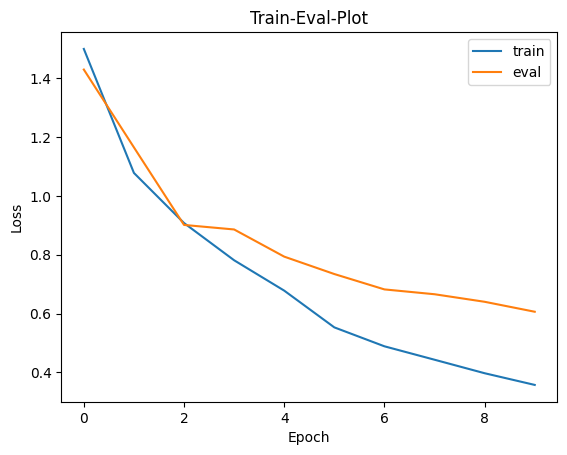

In [ ]:
plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Q2.a: Compared to the CNN in Q1 (without batch normlization), the performance of the model has improved in all mentioned metrics Loss, Top1, Top5. This is also visible by comparing their learning curves.

<br>
<br>
<br>

b) Throughout training, we optimize our parameters on the training set. This does not guarantee that with every step we also improve on validation and test set as well! Hence, there is no reason for our latest training checkpoint (the last checkpoint after the last epoch) to be the best to keep. One simple idea is to save a checkpoint of the best model for the validation set throughout the training. Meanining that as the training proceeds, we keep checking our **validation** accuracy after each epoch (or every N epochs) and save the best model. This can mitigate overfitting, as if the model overfits to training data (and accuracy on validation set drops), we would still have access to the best model checkpoint! Note that you **should not** do this on the test set, as we are not alowed to optimize **anything** (including the checkpoint selection) on the test set.

For this task, you need add the logic for saving the `best model` during the training. In the `src/trainers/base_trainer`, in method `train()` we already have the call to `self.evaluate()`. All you need to add is to process the returned result (a dictionary of metric_key -> metric_value) and see if you should save a checkpoint of the model. If yes, then you can save a checkpoint at `self.checkpoint_dir` under `best_val_model.pth` or a similar name, using the `save_model()` method. Feel free to define additional class attributes or methods if needed.

We also recommend adding a few prints, such as the epochs that you save the best model at. You can also use the `self.logger` object.

Please also implement the `should_evaluate()` in the `trainers/base_tariner.py`, which allows for doing the cross-validation evaluation in intervals, based on the config.


Increase the training epochs to 50 in Q1.a and Q2.a (simply edit their config dictionaries), and compare the **best model** and **latest model** on the **training set** and **validation set**. Due to the randomness, you can train multiple times to verify and observe overfitting and early stopping. (5 points)


Feel free to add any needed train/evaluation code below for this task.

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN already exists!Existing checkpoints will be overwritten!
Number of trainable parameters in each layer: 
 3456
 128
 589824
 512
 2359296
 512
 2359296
 512
 2359296
 512
 262144
 512
 5120
 10
 Total number of parameters i

Train Epoch: 1 Loss: 1.5563: : 100% 45000/45000 [00:43<00:00, 1043.75it/s]
Eval Loss: 1.5787: : 100% 5000/5000 [00:17<00:00, 289.60it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.611124792098999


Train Epoch: 2 Loss: 1.2114: : 100% 45000/45000 [00:41<00:00, 1085.90it/s]
Eval Loss: 1.1008: : 100% 5000/5000 [00:17<00:00, 292.67it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.611124792098999, Current: 1.1234153127670288


Train Epoch: 3 Loss: 0.8583: : 100% 45000/45000 [00:41<00:00, 1080.97it/s]
Eval Loss: 0.8997: : 100% 5000/5000 [00:17<00:00, 282.84it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.1234153127670288, Current: 0.967629919052124


Train Epoch: 4 Loss: 0.9269: : 100% 45000/45000 [00:41<00:00, 1082.26it/s]
Eval Loss: 0.8558: : 100% 5000/5000 [00:17<00:00, 285.20it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.967629919052124, Current: 0.8591767835617066


Train Epoch: 5 Loss: 0.6417: : 100% 45000/45000 [00:41<00:00, 1085.94it/s]
Eval Loss: 0.7349: : 100% 5000/5000 [00:17<00:00, 282.41it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.8591767835617066, Current: 0.7944427537918091


Train Epoch: 6 Loss: 0.6504: : 100% 45000/45000 [00:41<00:00, 1088.21it/s]
Eval Loss: 0.6528: : 100% 5000/5000 [00:17<00:00, 291.86it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7944427537918091, Current: 0.7168311190605163


Train Epoch: 7 Loss: 0.6338: : 100% 45000/45000 [00:41<00:00, 1080.76it/s]
Eval Loss: 0.6957: : 100% 5000/5000 [00:17<00:00, 289.57it/s] 
Train Epoch: 8 Loss: 0.5502: : 100% 45000/45000 [00:40<00:00, 1101.77it/s]
Eval Loss: 0.6110: : 100% 5000/5000 [00:16<00:00, 299.63it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7168311190605163, Current: 0.6510518360137939


Train Epoch: 9 Loss: 0.6065: : 100% 45000/45000 [00:40<00:00, 1101.34it/s]
Eval Loss: 0.7008: : 100% 5000/5000 [00:16<00:00, 300.55it/s] 
Train Epoch: 10 Loss: 0.6447: : 100% 45000/45000 [00:41<00:00, 1094.05it/s]
Eval Loss: 0.6878: : 100% 5000/5000 [00:17<00:00, 282.51it/s] 
Train Epoch: 11 Loss: 0.3617: : 100% 45000/45000 [00:41<00:00, 1071.62it/s]
Eval Loss: 0.5121: : 100% 5000/5000 [00:18<00:00, 276.74it/s] 
Train Epoch: 12 Loss: 0.3671: : 100% 45000/45000 [00:41<00:00, 1075.81it/s]
Eval Loss: 0.6664: : 100% 5000/5000 [00:17<00:00, 281.73it/s] 
Train Epoch: 13 Loss: 0.3858: : 100% 45000/45000 [00:41<00:00, 1080.98it/s]
Eval Loss: 0.6094: : 100% 5000/5000 [00:17<00:00, 281.72it/s] 
Train Epoch: 14 Loss: 0.2846: : 100% 45000/45000 [00:41<00:00, 1074.95it/s]
Eval Loss: 0.6751: : 100% 5000/5000 [00:17<00:00, 279.10it/s] 
Train Epoch: 15 Loss: 0.3984: : 100% 45000/45000 [00:41<00:00, 1071.93it/s]
Eval Loss: 0.6746: : 100% 5000/5000 [00:17<00:00, 279.07it/s] 
Train Epoch: 16 Loss: 0.2720

{'loss': 0.6850779891014099, 'top1': 0.7684999999999998, 'top5': 0.9845999999999997}


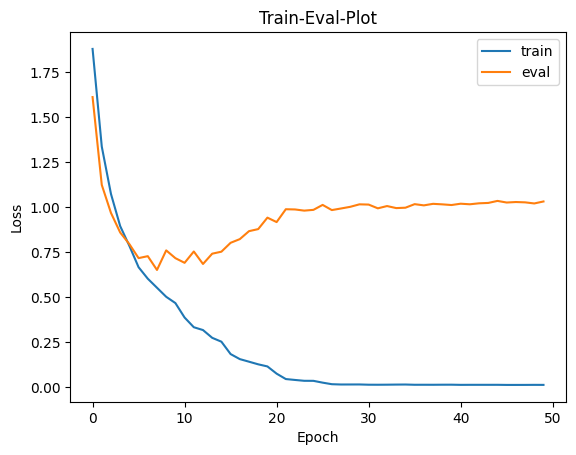

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q1_config = cnn_cifar10.q1_experiment

datamodule_class = q1_config['datamodule']
data_args = q1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()


# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Number of trainable parameters in each layer: 
 3456
 128
 128
 128
 589824
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 262144
 512
 5120
 10
 Total number of parameters is 7945482


Train Epoch: 1 Loss: 1.2515: : 100% 45000/45000 [00:22<00:00, 2028.30it/s]
Eval Loss: 1.8126: : 100% 5000/5000 [00:06<00:00, 739.65it/s]


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.8641530275344849


Train Epoch: 2 Loss: 1.1587: : 100% 45000/45000 [00:21<00:00, 2060.17it/s]
Eval Loss: 1.3899: : 100% 5000/5000 [00:08<00:00, 609.01it/s]


Saved model on eval based on eval_loss at this step. Previous: 1.8641530275344849, Current: 1.3962665176391602


Train Epoch: 3 Loss: 0.7964: : 100% 45000/45000 [00:21<00:00, 2137.16it/s]
Eval Loss: 0.9357: : 100% 5000/5000 [00:06<00:00, 802.42it/s]


Saved model on eval based on eval_loss at this step. Previous: 1.3962665176391602, Current: 0.9107777762413025


Train Epoch: 4 Loss: 0.6885: : 100% 45000/45000 [00:21<00:00, 2115.09it/s]
Eval Loss: 0.9865: : 100% 5000/5000 [00:08<00:00, 566.47it/s]
Train Epoch: 5 Loss: 0.8200: : 100% 45000/45000 [00:21<00:00, 2109.54it/s]
Eval Loss: 0.8909: : 100% 5000/5000 [00:06<00:00, 800.84it/s]


Saved model on eval based on eval_loss at this step. Previous: 0.9107777762413025, Current: 0.8196166467666626


Train Epoch: 6 Loss: 0.5675: : 100% 45000/45000 [00:21<00:00, 2106.01it/s]
Eval Loss: 0.6075: : 100% 5000/5000 [00:09<00:00, 554.66it/s]


Saved model on eval based on eval_loss at this step. Previous: 0.8196166467666626, Current: 0.6312777638435364


Train Epoch: 7 Loss: 0.5546: : 100% 45000/45000 [00:20<00:00, 2150.81it/s]
Eval Loss: 0.7583: : 100% 5000/5000 [00:06<00:00, 806.11it/s]
Train Epoch: 8 Loss: 0.4716: : 100% 45000/45000 [00:20<00:00, 2143.74it/s]
Eval Loss: 0.5375: : 100% 5000/5000 [00:08<00:00, 583.75it/s]


Saved model on eval based on eval_loss at this step. Previous: 0.6312777638435364, Current: 0.6113633322715759


Train Epoch: 9 Loss: 0.5157: : 100% 45000/45000 [00:20<00:00, 2158.44it/s]
Eval Loss: 0.6622: : 100% 5000/5000 [00:06<00:00, 800.99it/s]
Train Epoch: 10 Loss: 0.2697: : 100% 45000/45000 [00:20<00:00, 2163.15it/s]
Eval Loss: 0.7524: : 100% 5000/5000 [00:08<00:00, 579.28it/s]
Train Epoch: 11 Loss: 0.3647: : 100% 45000/45000 [00:20<00:00, 2165.97it/s]
Eval Loss: 0.7277: : 100% 5000/5000 [00:06<00:00, 780.55it/s]
Train Epoch: 12 Loss: 0.2718: : 100% 45000/45000 [00:20<00:00, 2168.72it/s]
Eval Loss: 0.6480: : 100% 5000/5000 [00:08<00:00, 558.42it/s]
Train Epoch: 13 Loss: 0.2362: : 100% 45000/45000 [00:20<00:00, 2186.60it/s]
Eval Loss: 0.7949: : 100% 5000/5000 [00:06<00:00, 798.79it/s]
Train Epoch: 14 Loss: 0.2234: : 100% 45000/45000 [00:20<00:00, 2162.59it/s]
Eval Loss: 0.6192: : 100% 5000/5000 [00:08<00:00, 586.41it/s]
Train Epoch: 15 Loss: 0.2274: : 100% 45000/45000 [00:20<00:00, 2176.77it/s]
Eval Loss: 0.6679: : 100% 5000/5000 [00:06<00:00, 804.54it/s]
Train Epoch: 16 Loss: 0.1356: : 100

{'loss': 0.6236244589090347, 'top1': 0.7923, 'top5': 0.9873999999999998}


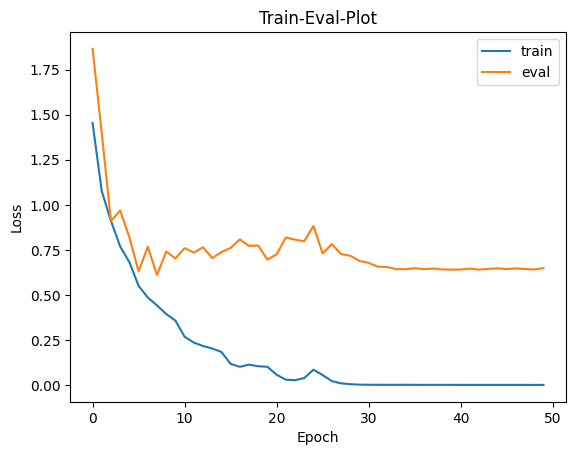

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2a_config = cnn_cifar10.q2a_normalization_experiment

datamodule_class = q2a_config['datamodule']
data_args = q2a_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q2a_config['trainer_module']
trainer_cnn = trainer_class(
    config = q2a_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()


# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q2a/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Q2.b: According to the results nad learning curve, we see that after some epochs, while training curve is getting better (loss is decreasing), validation curve is not showing any improvement. (Or even in the first case it is getting worse). This is the sign of overfitting. This illustrates that because of some reasons like high-complexity of our model, restriction of training data, etc. we have to apply compensating methods such as augmentation, dropouting, early stopping and etc.

<br>
<br>
<br>

c) While in part `b` we save the best model, we still do as many epochs as indicated in the config file. This is not convenient as the overfitting steps are wasting time and compute and also wouldn't affect the best model. Hence, Early Stopping can be helpful, where we **stop** the training after a few non-improving steps! Early stopping logic should be considered after every training epoch is finished, to see if we should do more epochs or not. Therefore, the logic should should be implemented ath the end of the loop over epochs in the `train()` method of `base_trainer.py` (which takes care of running multiple epochs).

Once implemented, you need a new config dictionary to enable early stopping. Simply create a new one at the bottom of `cfgs/exercise-3/cnn_cifar10.py`. It should be mostly similar to previous config, with the following modification:
```Python
q2c_earlystop_experiment = dict(
    name = 'Some New Name' # Otherwise it will overwrite previous experiment!
    ...
    trainer = dict(
        ...
        monitor = "off", # -> chante to "max eval_top1"
        early_stop = 0, #  -> change to 4
    ),
)
```
This will enable the early stopping to be considered for `eval_top1` metric and the maximum number of non-improving steps will be set to 4.

Use the cells below to re-run one of the experiments from part `b` that the best epoch was way lower than the total number of epochs, and see if early stopping can prevent unnecessary training epochs in that case.

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Number of trainable parameters in each layer: 
 3456
 128
 128
 128
 589824
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 262144
 512
 5120
 10
 Total number of parameters is 7945482


Train Epoch: 1 Loss: 1.1516: : 100% 45000/45000 [00:21<00:00, 2125.06it/s]
Eval Loss: 1.5272: : 100% 5000/5000 [00:06<00:00, 752.63it/s]


Saved model on eval based on eval_top1 at this step. Previous: -inf, Current: 0.47160000000000013


Train Epoch: 2 Loss: 1.1099: : 100% 45000/45000 [00:23<00:00, 1914.12it/s]
Eval Loss: 1.1287: : 100% 5000/5000 [00:06<00:00, 785.98it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.47160000000000013, Current: 0.6046


Train Epoch: 3 Loss: 0.7933: : 100% 45000/45000 [00:21<00:00, 2097.98it/s]
Eval Loss: 0.8177: : 100% 5000/5000 [00:08<00:00, 600.26it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.6046, Current: 0.6886


Train Epoch: 4 Loss: 0.8375: : 100% 45000/45000 [00:21<00:00, 2102.21it/s]
Eval Loss: 0.9307: : 100% 5000/5000 [00:06<00:00, 791.92it/s]
Train Epoch: 5 Loss: 0.6415: : 100% 45000/45000 [00:20<00:00, 2145.69it/s]
Eval Loss: 0.8974: : 100% 5000/5000 [00:08<00:00, 570.71it/s]
Train Epoch: 6 Loss: 0.7145: : 100% 45000/45000 [00:20<00:00, 2152.92it/s]
Eval Loss: 0.7043: : 100% 5000/5000 [00:06<00:00, 780.39it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.6886, Current: 0.7714


Train Epoch: 7 Loss: 0.4628: : 100% 45000/45000 [00:20<00:00, 2163.47it/s]
Eval Loss: 0.5818: : 100% 5000/5000 [00:09<00:00, 543.58it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.7714, Current: 0.7808000000000002


Train Epoch: 8 Loss: 0.4770: : 100% 45000/45000 [00:20<00:00, 2172.06it/s]
Eval Loss: 0.5622: : 100% 5000/5000 [00:06<00:00, 785.50it/s]
Train Epoch: 9 Loss: 0.4496: : 100% 45000/45000 [00:21<00:00, 2141.57it/s]
Eval Loss: 0.5585: : 100% 5000/5000 [00:08<00:00, 560.38it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.7808000000000002, Current: 0.7881999999999998


Train Epoch: 10 Loss: 0.4467: : 100% 45000/45000 [00:20<00:00, 2174.08it/s]
Eval Loss: 0.5966: : 100% 5000/5000 [00:06<00:00, 787.87it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.7881999999999998, Current: 0.795


Train Epoch: 11 Loss: 0.3294: : 100% 45000/45000 [00:21<00:00, 2075.08it/s]
Eval Loss: 0.6986: : 100% 5000/5000 [00:08<00:00, 576.13it/s]
Train Epoch: 12 Loss: 0.3707: : 100% 45000/45000 [00:21<00:00, 2129.99it/s]
Eval Loss: 0.5338: : 100% 5000/5000 [00:06<00:00, 801.56it/s]
Train Epoch: 13 Loss: 0.2891: : 100% 45000/45000 [00:21<00:00, 2122.53it/s]
Eval Loss: 0.6095: : 100% 5000/5000 [00:08<00:00, 587.74it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.795, Current: 0.8016000000000001


Train Epoch: 14 Loss: 0.1745: : 100% 45000/45000 [00:20<00:00, 2180.77it/s]
Eval Loss: 0.5567: : 100% 5000/5000 [00:06<00:00, 799.74it/s]
Train Epoch: 15 Loss: 0.1496: : 100% 45000/45000 [00:21<00:00, 2112.89it/s]
Eval Loss: 0.6644: : 100% 5000/5000 [00:08<00:00, 596.72it/s]
Train Epoch: 16 Loss: 0.3149: : 100% 45000/45000 [00:20<00:00, 2185.64it/s]
Eval Loss: 0.5932: : 100% 5000/5000 [00:06<00:00, 801.42it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.8016000000000001, Current: 0.8123999999999997


Train Epoch: 17 Loss: 0.0894: : 100% 45000/45000 [00:21<00:00, 2112.04it/s]
Eval Loss: 0.6760: : 100% 5000/5000 [00:08<00:00, 597.32it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.8123999999999997, Current: 0.8130000000000002


Train Epoch: 18 Loss: 0.2303: : 100% 45000/45000 [00:20<00:00, 2170.20it/s]
Eval Loss: 0.6437: : 100% 5000/5000 [00:06<00:00, 786.61it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.8130000000000002, Current: 0.8178


Train Epoch: 19 Loss: 0.1785: : 100% 45000/45000 [00:20<00:00, 2148.21it/s]
Eval Loss: 0.6106: : 100% 5000/5000 [00:08<00:00, 594.95it/s]
Train Epoch: 20 Loss: 0.1676: : 100% 45000/45000 [00:20<00:00, 2230.76it/s]
Eval Loss: 0.5655: : 100% 5000/5000 [00:06<00:00, 780.78it/s]
Train Epoch: 21 Loss: 0.0431: : 100% 45000/45000 [00:20<00:00, 2155.01it/s]
Eval Loss: 0.6183: : 100% 5000/5000 [00:08<00:00, 578.73it/s]
Train Epoch: 22 Loss: 0.0333: : 100% 45000/45000 [00:20<00:00, 2215.70it/s]
Eval Loss: 0.6647: : 100% 5000/5000 [00:06<00:00, 774.17it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.8178, Current: 0.8205999999999999


Train Epoch: 23 Loss: 0.0142: : 100% 45000/45000 [00:21<00:00, 2132.29it/s]
Eval Loss: 0.7253: : 100% 5000/5000 [00:08<00:00, 562.64it/s]


Saved model on eval based on eval_top1 at this step. Previous: 0.8205999999999999, Current: 0.8226


Train Epoch: 24 Loss: 0.0477: : 100% 45000/45000 [00:20<00:00, 2184.33it/s]
Eval Loss: 0.7903: : 100% 5000/5000 [00:06<00:00, 785.42it/s]
Train Epoch: 25 Loss: 0.0653: : 100% 45000/45000 [00:20<00:00, 2149.68it/s]
Eval Loss: 0.9574: : 100% 5000/5000 [00:08<00:00, 569.12it/s]
Train Epoch: 26 Loss: 0.0816: : 100% 45000/45000 [00:20<00:00, 2153.18it/s]
Eval Loss: 0.7236: : 100% 5000/5000 [00:06<00:00, 798.34it/s]
Train Epoch: 27 Loss: 0.0155: : 100% 45000/45000 [00:20<00:00, 2217.58it/s]
Eval Loss: 0.8075: : 100% 5000/5000 [00:08<00:00, 573.39it/s]
Eval Loss: 0.8273: : 100% 10000/10000 [00:14<00:00, 707.68it/s]


{'loss': 0.803303906917572, 'top1': 0.8092000000000003, 'top5': 0.9849000000000001}


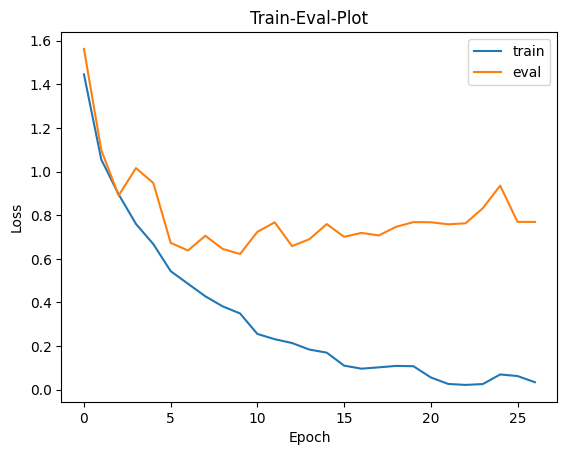

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q2c_config = cnn_cifar10.q2c_earlystop_experiment

datamodule_class = q2c_config['datamodule']
data_args = q2c_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it




trainer_class = q2c_config['trainer_module']
trainer_cnn = trainer_class(
    config = q2c_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()


# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q2c/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Q2.c: In this question, the model is similar to model we trained on Q2.a. We see that although the number of training epochs is specified as 50 in the config file, the training process is stopped at epoch around 25. That is the strategy of early stopping. In this way, we prevent additional training effort when no improvment is visited in some successive epochs.
<br>
<br>
<br>

### Question 3: Improve generalization of Convolutional Networks (10 points)

We saw in Q2 that the model can start over-fitting to the training set if we continue training for long. To prevent over-fitting, there are two main paradigms we can focus on.

The first is to get more training data. This might be a difficult and expensive process. However, it is generally the most effective way to learn more general models. A cheaper alternative is to perform data augmentation. The second approach is to regularize the model to prevent overfitting.

In the following sub-questions, we will experiment with each of these paradigms and measure the effect on the model generalization. We recommend disabling Early Stopping from previous question (simply removing it from config file) so that it does not interrupt your experiments with data augmentations and you maintain full control over number of epochs.



a) Data augmentation is the process of creating more training data by applying certain transformations to the training set images. Usually, the underlying assumption is that the label of the image does not change under the applied transformations. This includes geometric transformations like translation, rotation, scaling, flipping, random cropping, and color transformations like greyscale, colorjitter. For every image in the training batch, a random transformation is sampled from the possible ones (e.g., a random number of pixels to translate the image by) and is applied to the image. While designing the data input pipeline, we must choose the hyper-parameters for these transformations (e.g., limits of translation or rotation) based on things we expect to see in the test-set/real world. Your task in this question is to implement the data augmentation for the CIFAR-10 classification task. Many of these transformations are implemented in the `torchvision.transforms` package. Familiarize yourself with the APIs of these transforms, and functions to compose multiple transforms or randomly sample them. Next, implement geometric and color space data augmentations for the CIFAR-10 dataset, by choosing the right functions and order of application. Tune the hyper-parameters of these data augmentations to improve the validation performance. You will need to train the model a bit longer (20-30 epochs) with data augmentation, as the training data is effectively larger now. Discuss which augmentations work well for you in the report. (6 points)

Create as many config dictionaries as you need in `cnn_cifar10.py`. For every augmentation, simply create a new preset under `src/utils/transform_presets.py` and reference its name in your experiment's config dict.



b) Dropout is a popular scheme to regularize the model to improve generalization. The dropout layer works by setting the input activations randomly to zero at the output. You can implement Dropout by adding the `torch.nn.Dropout` layer between the conv blocks in your model. The layer has a single hyper-parameter $p$, which is the probability of dropping the input activations. High values of $p$ regularize the model heavily and decrease model capacity, but with low values, the model might overfit. Find the right hyper-parameter for $p$ by training the model for different values of $p$ and comparing training validation and validation accuracies. You can use the same parameter $p$ for all layers. You can also disable the data augmentation from the previous step while running this experiment, to clearly see the benefit of dropout. Show the plot of training and validation accuracies for different values of dropout (0.1 - 0.9) in the report. Create as many config dictionaries as you need in `cnn_cifar10.py`. (4 points)

transforms for preset CIFAR10_Flip_Rotate for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_Flip_Rotate for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_q3a_aug1.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_q3a_aug1 already exists!Existing checkpoints will be overwritten!
Numb

Train Epoch: 1 Loss: 1.2522: : 100% 45000/45000 [00:45<00:00, 986.24it/s] 
Eval Loss: 1.3783: : 100% 5000/5000 [00:17<00:00, 288.20it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.4483945226669313


Train Epoch: 2 Loss: 0.9716: : 100% 45000/45000 [00:43<00:00, 1025.07it/s]
Eval Loss: 1.2148: : 100% 5000/5000 [00:17<00:00, 285.75it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.4483945226669313, Current: 1.169583921432495


Train Epoch: 3 Loss: 1.0948: : 100% 45000/45000 [00:44<00:00, 1020.58it/s]
Eval Loss: 0.9335: : 100% 5000/5000 [00:17<00:00, 289.46it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.169583921432495, Current: 1.0366849732398986


Train Epoch: 4 Loss: 0.9462: : 100% 45000/45000 [00:43<00:00, 1029.42it/s]
Eval Loss: 0.9797: : 100% 5000/5000 [00:17<00:00, 283.86it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.0366849732398986, Current: 0.93590891122818


Train Epoch: 5 Loss: 0.6209: : 100% 45000/45000 [00:43<00:00, 1033.44it/s]
Eval Loss: 0.7890: : 100% 5000/5000 [00:17<00:00, 289.49it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.93590891122818, Current: 0.8788061547279358


Train Epoch: 6 Loss: 0.6002: : 100% 45000/45000 [00:43<00:00, 1028.82it/s]
Eval Loss: 0.7638: : 100% 5000/5000 [00:17<00:00, 293.33it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.8788061547279358, Current: 0.7942691898345947


Train Epoch: 7 Loss: 0.7051: : 100% 45000/45000 [00:43<00:00, 1037.44it/s]
Eval Loss: 0.7340: : 100% 5000/5000 [00:17<00:00, 290.98it/s] 
Train Epoch: 8 Loss: 0.5728: : 100% 45000/45000 [00:43<00:00, 1034.31it/s]
Eval Loss: 0.6955: : 100% 5000/5000 [00:16<00:00, 300.16it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7942691898345947, Current: 0.7438995313644409


Train Epoch: 9 Loss: 0.6470: : 100% 45000/45000 [00:43<00:00, 1028.83it/s]
Eval Loss: 0.6146: : 100% 5000/5000 [00:16<00:00, 296.93it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7438995313644409, Current: 0.6533982980251313


Train Epoch: 10 Loss: 0.6268: : 100% 45000/45000 [00:43<00:00, 1040.22it/s]
Eval Loss: 0.5476: : 100% 5000/5000 [00:16<00:00, 299.81it/s] 
Train Epoch: 11 Loss: 0.4508: : 100% 45000/45000 [00:43<00:00, 1044.46it/s]
Eval Loss: 0.6889: : 100% 5000/5000 [00:16<00:00, 300.86it/s] 
Train Epoch: 12 Loss: 0.5509: : 100% 45000/45000 [00:43<00:00, 1038.38it/s]
Eval Loss: 0.7029: : 100% 5000/5000 [00:16<00:00, 300.66it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6533982980251313, Current: 0.6394043052196503


Train Epoch: 13 Loss: 0.4342: : 100% 45000/45000 [00:43<00:00, 1038.82it/s]
Eval Loss: 0.5850: : 100% 5000/5000 [00:16<00:00, 301.05it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6394043052196503, Current: 0.5820516705513


Train Epoch: 14 Loss: 0.5399: : 100% 45000/45000 [00:43<00:00, 1038.68it/s]
Eval Loss: 0.5668: : 100% 5000/5000 [00:16<00:00, 300.68it/s] 
Train Epoch: 15 Loss: 0.4867: : 100% 45000/45000 [00:43<00:00, 1043.07it/s]
Eval Loss: 0.5104: : 100% 5000/5000 [00:16<00:00, 300.72it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5820516705513, Current: 0.5312604486942292


Train Epoch: 16 Loss: 0.4041: : 100% 45000/45000 [00:43<00:00, 1039.72it/s]
Eval Loss: 0.5377: : 100% 5000/5000 [00:18<00:00, 271.11it/s] 
Train Epoch: 17 Loss: 0.4172: : 100% 45000/45000 [00:43<00:00, 1034.24it/s]
Eval Loss: 0.4968: : 100% 5000/5000 [00:16<00:00, 297.04it/s] 
Train Epoch: 18 Loss: 0.5927: : 100% 45000/45000 [00:43<00:00, 1042.55it/s]
Eval Loss: 0.5728: : 100% 5000/5000 [00:16<00:00, 301.53it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5312604486942292, Current: 0.5166406118869782


Train Epoch: 19 Loss: 0.3701: : 100% 45000/45000 [00:43<00:00, 1042.12it/s]
Eval Loss: 0.4749: : 100% 5000/5000 [00:17<00:00, 290.97it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5166406118869782, Current: 0.5101020967960358


Train Epoch: 20 Loss: 0.4087: : 100% 45000/45000 [00:43<00:00, 1030.33it/s]
Eval Loss: 0.5791: : 100% 5000/5000 [00:17<00:00, 293.33it/s] 
Train Epoch: 21 Loss: 0.3163: : 100% 45000/45000 [00:43<00:00, 1029.58it/s]
Eval Loss: 0.4749: : 100% 5000/5000 [00:17<00:00, 293.61it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5101020967960358, Current: 0.4830376207828522


Train Epoch: 22 Loss: 0.2833: : 100% 45000/45000 [00:43<00:00, 1030.44it/s]
Eval Loss: 0.4206: : 100% 5000/5000 [00:17<00:00, 293.27it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.4830376207828522, Current: 0.47772141695022585


Train Epoch: 23 Loss: 0.2462: : 100% 45000/45000 [00:43<00:00, 1030.20it/s]
Eval Loss: 0.3812: : 100% 5000/5000 [00:17<00:00, 292.70it/s] 
Train Epoch: 24 Loss: 0.4665: : 100% 45000/45000 [00:43<00:00, 1029.80it/s]
Eval Loss: 0.5061: : 100% 5000/5000 [00:17<00:00, 293.45it/s] 
Train Epoch: 25 Loss: 0.2653: : 100% 45000/45000 [00:43<00:00, 1033.47it/s]
Eval Loss: 0.4867: : 100% 5000/5000 [00:17<00:00, 293.89it/s] 
Eval Loss: 0.4750: : 100% 10000/10000 [00:15<00:00, 655.74it/s] 


{'loss': 0.46721612513065336, 'top1': 0.8442999999999996, 'top5': 0.9933999999999996}


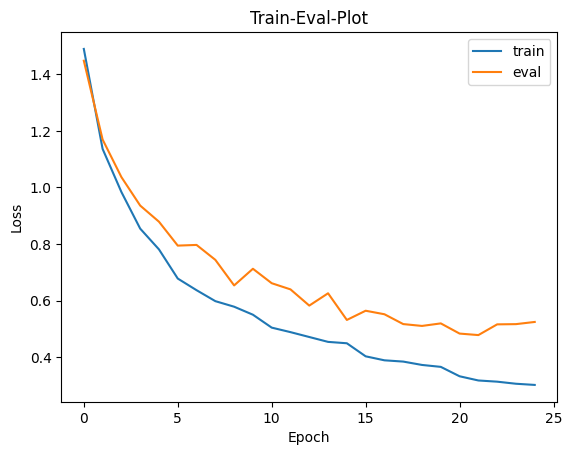

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_aug1_config = cnn_cifar10.q3a_aug1_experiment

datamodule_class = q3a_aug1_config['datamodule']
data_args = q3a_aug1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q3a_aug1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q3a_aug1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()



# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q3a_aug1/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

transforms for preset CIFAR10_Scale_Crop for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    RandomResizedCrop(size=(32, 32), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_Scale_Crop for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_q3a_aug2.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_q3a_aug2 already exists!Existing checkpoints will be overwritten!
Number 

Train Epoch: 1 Loss: 1.7048: : 100% 45000/45000 [00:43<00:00, 1032.97it/s]
Eval Loss: 1.7297: : 100% 5000/5000 [00:17<00:00, 290.60it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.7606227540969848


Train Epoch: 2 Loss: 1.6232: : 100% 45000/45000 [00:43<00:00, 1023.87it/s]
Eval Loss: 1.6970: : 100% 5000/5000 [00:16<00:00, 294.13it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.7606227540969848, Current: 1.7084033679962158


Train Epoch: 3 Loss: 1.5162: : 100% 45000/45000 [00:44<00:00, 1019.80it/s]
Eval Loss: 1.7335: : 100% 5000/5000 [00:17<00:00, 290.48it/s] 
Train Epoch: 4 Loss: 1.3997: : 100% 45000/45000 [00:43<00:00, 1023.23it/s]
Eval Loss: 1.4810: : 100% 5000/5000 [00:17<00:00, 287.08it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.7084033679962158, Current: 1.5138027000427245


Train Epoch: 5 Loss: 1.3316: : 100% 45000/45000 [00:43<00:00, 1023.93it/s]
Eval Loss: 1.3920: : 100% 5000/5000 [00:17<00:00, 290.89it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.5138027000427245, Current: 1.3784513425827027


Train Epoch: 6 Loss: 1.2567: : 100% 45000/45000 [00:43<00:00, 1023.25it/s]
Eval Loss: 1.2956: : 100% 5000/5000 [00:17<00:00, 291.12it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.3784513425827027, Current: 1.2436381387710571


Train Epoch: 7 Loss: 1.1087: : 100% 45000/45000 [00:43<00:00, 1028.25it/s]
Eval Loss: 1.0354: : 100% 5000/5000 [00:17<00:00, 287.41it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.2436381387710571, Current: 1.1594905042648316


Train Epoch: 8 Loss: 1.1866: : 100% 45000/45000 [00:43<00:00, 1024.53it/s]
Eval Loss: 1.0946: : 100% 5000/5000 [00:17<00:00, 290.42it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.1594905042648316, Current: 1.1540077495574952


Train Epoch: 9 Loss: 0.9914: : 100% 45000/45000 [00:43<00:00, 1027.75it/s]
Eval Loss: 1.1321: : 100% 5000/5000 [00:17<00:00, 284.68it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.1540077495574952, Current: 1.1093097305297852


Train Epoch: 10 Loss: 1.0104: : 100% 45000/45000 [00:43<00:00, 1029.17it/s]
Eval Loss: 1.0423: : 100% 5000/5000 [00:17<00:00, 287.17it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.1093097305297852, Current: 1.0756434750556947


Train Epoch: 11 Loss: 1.1122: : 100% 45000/45000 [00:43<00:00, 1024.76it/s]
Eval Loss: 1.0272: : 100% 5000/5000 [00:17<00:00, 291.26it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.0756434750556947, Current: 1.0062461233139037


Train Epoch: 12 Loss: 0.9728: : 100% 45000/45000 [00:43<00:00, 1028.25it/s]
Eval Loss: 0.9533: : 100% 5000/5000 [00:17<00:00, 286.50it/s] 
Train Epoch: 13 Loss: 0.8942: : 100% 45000/45000 [00:44<00:00, 1009.72it/s]
Eval Loss: 1.1562: : 100% 5000/5000 [00:16<00:00, 295.36it/s] 
Train Epoch: 14 Loss: 0.9860: : 100% 45000/45000 [00:43<00:00, 1026.03it/s]
Eval Loss: 1.0679: : 100% 5000/5000 [00:17<00:00, 287.73it/s] 
Train Epoch: 15 Loss: 0.9630: : 100% 45000/45000 [00:44<00:00, 1019.16it/s]
Eval Loss: 1.0341: : 100% 5000/5000 [00:17<00:00, 287.58it/s] 
Train Epoch: 16 Loss: 0.8423: : 100% 45000/45000 [00:43<00:00, 1023.38it/s]
Eval Loss: 0.9777: : 100% 5000/5000 [00:16<00:00, 294.81it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.0062461233139037, Current: 0.9769729495048523


Train Epoch: 17 Loss: 0.8749: : 100% 45000/45000 [00:43<00:00, 1024.63it/s]
Eval Loss: 0.9456: : 100% 5000/5000 [00:17<00:00, 290.84it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9769729495048523, Current: 0.9459439468383789


Train Epoch: 18 Loss: 0.8910: : 100% 45000/45000 [00:43<00:00, 1024.16it/s]
Eval Loss: 0.9689: : 100% 5000/5000 [00:17<00:00, 287.03it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9459439468383789, Current: 0.9330248045921326


Train Epoch: 19 Loss: 0.8666: : 100% 45000/45000 [00:44<00:00, 1019.91it/s]
Eval Loss: 0.9502: : 100% 5000/5000 [00:17<00:00, 290.70it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9330248045921326, Current: 0.9310391402244568


Train Epoch: 20 Loss: 0.8482: : 100% 45000/45000 [00:43<00:00, 1025.01it/s]
Eval Loss: 0.9172: : 100% 5000/5000 [00:17<00:00, 286.77it/s] 
Train Epoch: 21 Loss: 0.8653: : 100% 45000/45000 [00:44<00:00, 1020.39it/s]
Eval Loss: 0.8639: : 100% 5000/5000 [00:17<00:00, 290.15it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9310391402244568, Current: 0.9202600526809692


Train Epoch: 22 Loss: 0.9433: : 100% 45000/45000 [00:44<00:00, 1022.64it/s]
Eval Loss: 0.9826: : 100% 5000/5000 [00:17<00:00, 288.00it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9202600526809692, Current: 0.9054214572906494


Train Epoch: 23 Loss: 0.7924: : 100% 45000/45000 [00:44<00:00, 1019.94it/s]
Eval Loss: 0.9053: : 100% 5000/5000 [00:17<00:00, 284.18it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9054214572906494, Current: 0.868413290977478


Train Epoch: 24 Loss: 0.7420: : 100% 45000/45000 [00:43<00:00, 1029.52it/s]
Eval Loss: 1.0000: : 100% 5000/5000 [00:17<00:00, 291.14it/s] 
Train Epoch: 25 Loss: 0.9086: : 100% 45000/45000 [00:43<00:00, 1027.70it/s]
Eval Loss: 0.7973: : 100% 5000/5000 [00:17<00:00, 290.62it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.868413290977478, Current: 0.8273050570487976


Eval Loss: 0.5494: : 100% 10000/10000 [00:15<00:00, 636.80it/s]

{'loss': 0.6248266726732254, 'top1': 0.7926999999999998, 'top5': 0.9882}


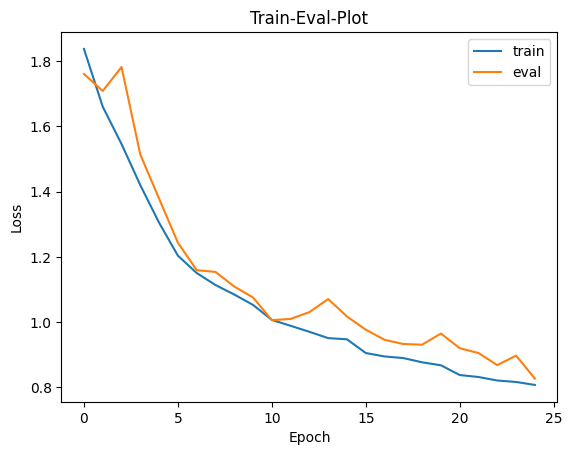

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_aug2_config = cnn_cifar10.q3a_aug2_experiment

datamodule_class = q3a_aug2_config['datamodule']
data_args = q3a_aug2_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q3a_aug2_config['trainer_module']
trainer_cnn = trainer_class(
    config = q3a_aug2_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()



# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q3a_aug2/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

transforms for preset CIFAR10_Color_Blur for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ColorJitter(brightness=(0.5, 1.5), contrast=None, saturation=None, hue=(-0.3, 0.3))
    GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5.0))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10_Color_Blur for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_q3a_aug3.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_q3a_aug3 already exists!Existing checkpoints wil

Train Epoch: 1 Loss: 1.8742: : 100% 45000/45000 [00:47<00:00, 946.47it/s] 
Eval Loss: 1.8604: : 100% 5000/5000 [00:16<00:00, 298.54it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.9117757177352905


Train Epoch: 2 Loss: 1.6325: : 100% 45000/45000 [00:43<00:00, 1030.02it/s]
Eval Loss: 1.8592: : 100% 5000/5000 [00:17<00:00, 292.43it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.9117757177352905, Current: 1.8793578147888184


Train Epoch: 3 Loss: 1.5506: : 100% 45000/45000 [00:43<00:00, 1025.63it/s]
Eval Loss: 1.5491: : 100% 5000/5000 [00:17<00:00, 283.82it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.8793578147888184, Current: 1.6014847326278687


Train Epoch: 4 Loss: 1.4722: : 100% 45000/45000 [00:43<00:00, 1025.30it/s]
Eval Loss: 1.7720: : 100% 5000/5000 [00:17<00:00, 289.31it/s] 
Train Epoch: 5 Loss: 1.4599: : 100% 45000/45000 [00:43<00:00, 1034.22it/s]
Eval Loss: 1.4349: : 100% 5000/5000 [00:17<00:00, 292.43it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.6014847326278687, Current: 1.4674034929275512


Train Epoch: 6 Loss: 1.3762: : 100% 45000/45000 [00:43<00:00, 1028.42it/s]
Eval Loss: 1.3755: : 100% 5000/5000 [00:17<00:00, 290.72it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.4674034929275512, Current: 1.3902103757858277


Train Epoch: 7 Loss: 1.3599: : 100% 45000/45000 [00:43<00:00, 1029.97it/s]
Eval Loss: 1.3064: : 100% 5000/5000 [00:17<00:00, 293.24it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.3902103757858277, Current: 1.355214614868164


Train Epoch: 8 Loss: 1.3181: : 100% 45000/45000 [00:43<00:00, 1030.35it/s]
Eval Loss: 1.4021: : 100% 5000/5000 [00:17<00:00, 288.77it/s] 
Train Epoch: 9 Loss: 1.1631: : 100% 45000/45000 [00:43<00:00, 1024.32it/s]
Eval Loss: 1.3524: : 100% 5000/5000 [00:17<00:00, 285.23it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.355214614868164, Current: 1.2978718757629395


Train Epoch: 10 Loss: 1.2650: : 100% 45000/45000 [00:43<00:00, 1023.24it/s]
Eval Loss: 1.2265: : 100% 5000/5000 [00:17<00:00, 286.04it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.2978718757629395, Current: 1.26385178565979


Train Epoch: 11 Loss: 1.1709: : 100% 45000/45000 [00:43<00:00, 1032.10it/s]
Eval Loss: 1.2554: : 100% 5000/5000 [00:16<00:00, 296.71it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.26385178565979, Current: 1.2395965719223023


Train Epoch: 12 Loss: 0.9745: : 100% 45000/45000 [00:43<00:00, 1033.88it/s]
Eval Loss: 1.2533: : 100% 5000/5000 [00:17<00:00, 289.20it/s] 
Train Epoch: 13 Loss: 1.0873: : 100% 45000/45000 [00:43<00:00, 1036.96it/s]
Eval Loss: 1.1661: : 100% 5000/5000 [00:16<00:00, 298.95it/s] 
Train Epoch: 14 Loss: 1.1160: : 100% 45000/45000 [00:43<00:00, 1031.05it/s]
Eval Loss: 1.2603: : 100% 5000/5000 [00:16<00:00, 299.91it/s] 
Train Epoch: 15 Loss: 1.1210: : 100% 45000/45000 [00:43<00:00, 1038.64it/s]
Eval Loss: 1.1779: : 100% 5000/5000 [00:17<00:00, 288.84it/s] 
Train Epoch: 16 Loss: 0.9637: : 100% 45000/45000 [00:44<00:00, 1015.68it/s]
Eval Loss: 1.1526: : 100% 5000/5000 [00:17<00:00, 293.86it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.2395965719223023, Current: 1.2338953971862794


Train Epoch: 17 Loss: 0.9170: : 100% 45000/45000 [00:43<00:00, 1035.37it/s]
Eval Loss: 1.2338: : 100% 5000/5000 [00:17<00:00, 292.58it/s] 
Train Epoch: 18 Loss: 0.9854: : 100% 45000/45000 [00:43<00:00, 1030.72it/s]
Eval Loss: 1.3362: : 100% 5000/5000 [00:16<00:00, 300.48it/s] 
Train Epoch: 19 Loss: 1.0252: : 100% 45000/45000 [00:43<00:00, 1039.32it/s]
Eval Loss: 1.2650: : 100% 5000/5000 [00:17<00:00, 288.59it/s] 
Train Epoch: 20 Loss: 0.9266: : 100% 45000/45000 [00:43<00:00, 1025.78it/s]
Eval Loss: 1.2440: : 100% 5000/5000 [00:17<00:00, 293.84it/s] 
Train Epoch: 21 Loss: 0.8440: : 100% 45000/45000 [00:43<00:00, 1030.68it/s]
Eval Loss: 1.3203: : 100% 5000/5000 [00:16<00:00, 303.00it/s] 
Train Epoch: 22 Loss: 0.8096: : 100% 45000/45000 [00:43<00:00, 1025.18it/s]
Eval Loss: 1.3091: : 100% 5000/5000 [00:16<00:00, 300.37it/s] 
Train Epoch: 23 Loss: 0.7283: : 100% 45000/45000 [00:43<00:00, 1033.28it/s]
Eval Loss: 1.3080: : 100% 5000/5000 [00:17<00:00, 293.16it/s] 
Train Epoch: 24 Loss: 0.793

{'loss': 10.171743679046632, 'top1': 0.20710000000000003, 'top5': 0.7063999999999999}


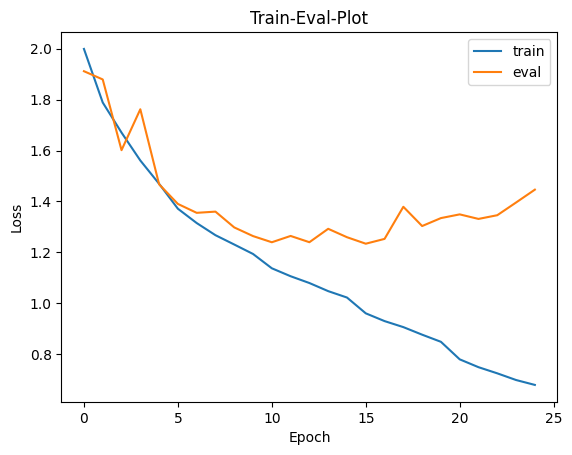

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3a_aug3_config = cnn_cifar10.q3a_aug3_experiment

datamodule_class = q3a_aug3_config['datamodule']
data_args = q3a_aug3_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q3a_aug3_config['trainer_module']
trainer_cnn = trainer_class(
    config = q3a_aug3_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list  = trainer_cnn.train()



# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q3a_aug3/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Q3.a: For this experiment, we have defined three configs called as following: q3a_aug3_experiment, q3a_aug2_experiment, and q3a_aug1_experiment

In q3a_aug1_experiment, we have used random horizontal flipping (probability of 0.5 ) and a light rotation (-10 to 10 degree). Our performance has improved by value of 4 on top1 accuracy. Moreover, we do not see any sign of overfitting on the curve until epoch 25. Accordingly, we might get even better results if we increase the training epochs.

In q3a_aug2_experiment, we have applied random resizing and cropping at the same time by a built-in function. The result has not imporved. However, we do not see any sign of overfitting till the last epoch (epoch 25). So, we can increase the training epoch and hopefully modify our results of our base model.

In, q3a_aug3_experiment, we have touched the color space. Our results show that by using Color-Jitter nad Gaussian-Blur separately, we could niether improve the performce nor prevent overfitting. Also, we can learn that using augmentation in color-space should get applied on both training and evaluation data.

According to the result, we can assert that our geometric transformations of aug1 have been more useful than color space transformations of aug3 and geometrics of aug2. One can combine them and get better results.

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Number of trainable parameters in each layer: 
 3456
 128
 128
 128
 589824
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 262144
 512
 5120
 10
 Total number of parameters is 7945482


Train Epoch: 1 Loss: 1.3017: : 100% 45000/45000 [00:44<00:00, 1021.09it/s]
Eval Loss: 1.2264: : 100% 5000/5000 [00:16<00:00, 300.47it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.2427349853515626


Train Epoch: 2 Loss: 1.1534: : 100% 45000/45000 [00:44<00:00, 1021.51it/s]
Eval Loss: 1.0280: : 100% 5000/5000 [00:16<00:00, 295.47it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.2427349853515626, Current: 1.084611496925354


Train Epoch: 3 Loss: 1.0029: : 100% 45000/45000 [00:44<00:00, 1017.68it/s]
Eval Loss: 1.0976: : 100% 5000/5000 [00:16<00:00, 296.10it/s] 
Train Epoch: 4 Loss: 0.9342: : 100% 45000/45000 [00:43<00:00, 1030.56it/s]
Eval Loss: 0.9115: : 100% 5000/5000 [00:16<00:00, 296.48it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.084611496925354, Current: 0.9071467351913453


Train Epoch: 5 Loss: 0.8917: : 100% 45000/45000 [00:43<00:00, 1031.12it/s]
Eval Loss: 0.7148: : 100% 5000/5000 [00:16<00:00, 296.07it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9071467351913453, Current: 0.7831832337379455


Train Epoch: 6 Loss: 0.6329: : 100% 45000/45000 [00:43<00:00, 1031.45it/s]
Eval Loss: 0.6671: : 100% 5000/5000 [00:16<00:00, 299.24it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7831832337379455, Current: 0.7150585079193115


Train Epoch: 7 Loss: 0.7679: : 100% 45000/45000 [00:43<00:00, 1027.43it/s]
Eval Loss: 0.6139: : 100% 5000/5000 [00:16<00:00, 299.51it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7150585079193115, Current: 0.6311054039001465


Train Epoch: 8 Loss: 0.6301: : 100% 45000/45000 [00:43<00:00, 1030.32it/s]
Eval Loss: 0.6164: : 100% 5000/5000 [00:18<00:00, 276.27it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6311054039001465, Current: 0.6232971405982971


Train Epoch: 9 Loss: 0.7852: : 100% 45000/45000 [00:44<00:00, 1016.51it/s]
Eval Loss: 0.5607: : 100% 5000/5000 [00:16<00:00, 297.35it/s] 
Train Epoch: 10 Loss: 0.6034: : 100% 45000/45000 [00:43<00:00, 1030.24it/s]
Eval Loss: 0.5554: : 100% 5000/5000 [00:16<00:00, 295.36it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6232971405982971, Current: 0.5915685868263245


Train Epoch: 11 Loss: 0.4270: : 100% 45000/45000 [00:43<00:00, 1027.68it/s]
Eval Loss: 0.5429: : 100% 5000/5000 [00:16<00:00, 299.89it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5915685868263245, Current: 0.5313727915287018


Train Epoch: 12 Loss: 0.4693: : 100% 45000/45000 [00:43<00:00, 1031.72it/s]
Eval Loss: 0.4620: : 100% 5000/5000 [00:16<00:00, 299.71it/s] 
Train Epoch: 13 Loss: 0.4341: : 100% 45000/45000 [00:43<00:00, 1024.05it/s]
Eval Loss: 0.5016: : 100% 5000/5000 [00:16<00:00, 297.61it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5313727915287018, Current: 0.520185774564743


Train Epoch: 14 Loss: 0.4514: : 100% 45000/45000 [00:43<00:00, 1030.19it/s]
Eval Loss: 0.5922: : 100% 5000/5000 [00:17<00:00, 292.23it/s] 
Train Epoch: 15 Loss: 0.4044: : 100% 45000/45000 [00:43<00:00, 1026.64it/s]
Eval Loss: 0.5458: : 100% 5000/5000 [00:17<00:00, 292.95it/s] 
Train Epoch: 16 Loss: 0.3490: : 100% 45000/45000 [00:44<00:00, 1020.86it/s]
Eval Loss: 0.4076: : 100% 5000/5000 [00:17<00:00, 292.71it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.520185774564743, Current: 0.510493756532669


Train Epoch: 17 Loss: 0.4714: : 100% 45000/45000 [00:44<00:00, 1021.84it/s]
Eval Loss: 0.5316: : 100% 5000/5000 [00:16<00:00, 296.59it/s] 
Train Epoch: 18 Loss: 0.3555: : 100% 45000/45000 [00:43<00:00, 1025.47it/s]
Eval Loss: 0.4999: : 100% 5000/5000 [00:16<00:00, 295.49it/s] 
Train Epoch: 19 Loss: 0.3447: : 100% 45000/45000 [00:44<00:00, 1021.63it/s]
Eval Loss: 0.5790: : 100% 5000/5000 [00:17<00:00, 293.34it/s] 
Train Epoch: 20 Loss: 0.3174: : 100% 45000/45000 [00:43<00:00, 1030.55it/s]
Eval Loss: 0.4629: : 100% 5000/5000 [00:16<00:00, 296.12it/s] 
Train Epoch: 21 Loss: 0.1668: : 100% 45000/45000 [00:43<00:00, 1025.50it/s]
Eval Loss: 0.4739: : 100% 5000/5000 [00:17<00:00, 293.39it/s] 
Train Epoch: 22 Loss: 0.2498: : 100% 45000/45000 [00:43<00:00, 1026.11it/s]
Eval Loss: 0.4647: : 100% 5000/5000 [00:16<00:00, 295.79it/s] 
Train Epoch: 23 Loss: 0.2918: : 100% 45000/45000 [00:44<00:00, 1020.90it/s]
Eval Loss: 0.5279: : 100% 5000/5000 [00:17<00:00, 292.50it/s] 
Train Epoch: 24 Loss: 0.271

{'loss': 0.5478946197032929, 'top1': 0.8173999999999999, 'top5': 0.9903999999999995}


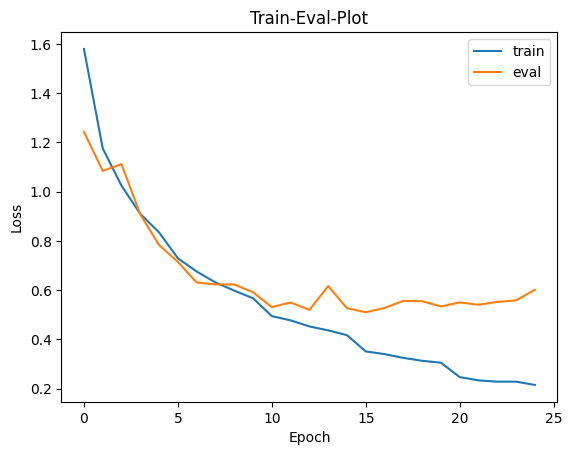

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3b_p1_config = cnn_cifar10.q3b_p1_dropout_experiment

datamodule_class = q3b_p1_config['datamodule']
data_args = q3b_p1_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q3b_p1_config['trainer_module']
trainer_cnn = trainer_class(
    config = q3b_p1_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list = trainer_cnn.train()


# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q3b_p1/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_q3b_p2.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_q3b_p2 already exists!Existing checkpoints will be overwritten!
Number of trainable parameters in each layer: 
 3456
 128
 128
 128
 589824
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 51

Train Epoch: 1 Loss: 1.4000: : 100% 45000/45000 [00:45<00:00, 986.00it/s] 
Eval Loss: 1.2551: : 100% 5000/5000 [00:16<00:00, 297.26it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 1.2939085578918457


Train Epoch: 2 Loss: 1.2008: : 100% 45000/45000 [00:43<00:00, 1026.11it/s]
Eval Loss: 1.1253: : 100% 5000/5000 [00:16<00:00, 296.24it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.2939085578918457, Current: 1.126153597831726


Train Epoch: 3 Loss: 1.1562: : 100% 45000/45000 [00:44<00:00, 1013.24it/s]
Eval Loss: 0.9636: : 100% 5000/5000 [00:16<00:00, 296.46it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.126153597831726, Current: 1.020516254901886


Train Epoch: 4 Loss: 1.1549: : 100% 45000/45000 [00:43<00:00, 1030.06it/s]
Eval Loss: 0.9910: : 100% 5000/5000 [00:16<00:00, 296.62it/s] 


Saved model on eval based on eval_loss at this step. Previous: 1.020516254901886, Current: 0.9578891158103943


Train Epoch: 5 Loss: 0.9356: : 100% 45000/45000 [00:43<00:00, 1027.81it/s]
Eval Loss: 0.9236: : 100% 5000/5000 [00:16<00:00, 295.66it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9578891158103943, Current: 0.9309378623962402


Train Epoch: 6 Loss: 0.7811: : 100% 45000/45000 [00:43<00:00, 1030.71it/s]
Eval Loss: 0.8347: : 100% 5000/5000 [00:16<00:00, 299.92it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.9309378623962402, Current: 0.8516331577301025


Train Epoch: 7 Loss: 0.9142: : 100% 45000/45000 [00:43<00:00, 1030.72it/s]
Eval Loss: 0.7867: : 100% 5000/5000 [00:17<00:00, 292.95it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.8516331577301025, Current: 0.7824544453620911


Train Epoch: 8 Loss: 0.8177: : 100% 45000/45000 [00:43<00:00, 1027.18it/s]
Eval Loss: 0.6877: : 100% 5000/5000 [00:16<00:00, 295.81it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7824544453620911, Current: 0.7136617469787597


Train Epoch: 9 Loss: 0.9078: : 100% 45000/45000 [00:43<00:00, 1025.19it/s]
Eval Loss: 0.7300: : 100% 5000/5000 [00:17<00:00, 286.23it/s] 
Train Epoch: 10 Loss: 0.9435: : 100% 45000/45000 [00:44<00:00, 1016.47it/s]
Eval Loss: 0.7038: : 100% 5000/5000 [00:17<00:00, 286.71it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7136617469787597, Current: 0.7099916315078736


Train Epoch: 11 Loss: 0.7717: : 100% 45000/45000 [00:44<00:00, 1007.53it/s]
Eval Loss: 0.6253: : 100% 5000/5000 [00:17<00:00, 290.06it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.7099916315078736, Current: 0.6210839819908142


Train Epoch: 12 Loss: 0.7898: : 100% 45000/45000 [00:44<00:00, 1015.81it/s]
Eval Loss: 0.5715: : 100% 5000/5000 [00:17<00:00, 283.22it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6210839819908142, Current: 0.6193004858493805


Train Epoch: 13 Loss: 0.7842: : 100% 45000/45000 [00:44<00:00, 1016.64it/s]
Eval Loss: 0.6094: : 100% 5000/5000 [00:17<00:00, 286.17it/s] 
Train Epoch: 14 Loss: 0.8313: : 100% 45000/45000 [00:44<00:00, 1020.47it/s]
Eval Loss: 0.6040: : 100% 5000/5000 [00:17<00:00, 286.69it/s] 
Train Epoch: 15 Loss: 0.8782: : 100% 45000/45000 [00:44<00:00, 1015.11it/s]
Eval Loss: 0.6465: : 100% 5000/5000 [00:17<00:00, 287.04it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6193004858493805, Current: 0.6124353396892548


Train Epoch: 16 Loss: 0.5935: : 100% 45000/45000 [00:44<00:00, 1016.61it/s]
Eval Loss: 0.5466: : 100% 5000/5000 [00:17<00:00, 289.52it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.6124353396892548, Current: 0.5608028328418732


Train Epoch: 17 Loss: 0.8257: : 100% 45000/45000 [00:44<00:00, 1006.15it/s]
Eval Loss: 0.5544: : 100% 5000/5000 [00:17<00:00, 291.41it/s] 
Train Epoch: 18 Loss: 0.5577: : 100% 45000/45000 [00:44<00:00, 1018.63it/s]
Eval Loss: 0.4940: : 100% 5000/5000 [00:17<00:00, 291.22it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5608028328418732, Current: 0.5386071038246155


Train Epoch: 19 Loss: 0.6844: : 100% 45000/45000 [00:44<00:00, 1016.63it/s]
Eval Loss: 0.5344: : 100% 5000/5000 [00:17<00:00, 293.35it/s] 
Train Epoch: 20 Loss: 0.6385: : 100% 45000/45000 [00:44<00:00, 1020.94it/s]
Eval Loss: 0.4910: : 100% 5000/5000 [00:17<00:00, 292.87it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5386071038246155, Current: 0.5219913744926452


Train Epoch: 21 Loss: 0.5940: : 100% 45000/45000 [00:44<00:00, 1022.48it/s]
Eval Loss: 0.4929: : 100% 5000/5000 [00:17<00:00, 293.04it/s] 
Train Epoch: 22 Loss: 0.5028: : 100% 45000/45000 [00:44<00:00, 1021.51it/s]
Eval Loss: 0.4966: : 100% 5000/5000 [00:17<00:00, 292.79it/s] 


Saved model on eval based on eval_loss at this step. Previous: 0.5219913744926452, Current: 0.4981346416473389


Train Epoch: 23 Loss: 0.7579: : 100% 45000/45000 [00:44<00:00, 1016.88it/s]
Eval Loss: 0.4910: : 100% 5000/5000 [00:17<00:00, 292.87it/s] 
Train Epoch: 24 Loss: 0.6373: : 100% 45000/45000 [00:43<00:00, 1025.75it/s]
Eval Loss: 0.4651: : 100% 5000/5000 [00:17<00:00, 292.80it/s] 
Train Epoch: 25 Loss: 0.5698: : 100% 45000/45000 [00:44<00:00, 1020.61it/s]
Eval Loss: 0.5093: : 100% 5000/5000 [00:17<00:00, 293.08it/s] 
Eval Loss: 0.6030: : 100% 10000/10000 [00:15<00:00, 655.08it/s]


{'loss': 0.5271052247285843, 'top1': 0.8198000000000001, 'top5': 0.9905999999999995}


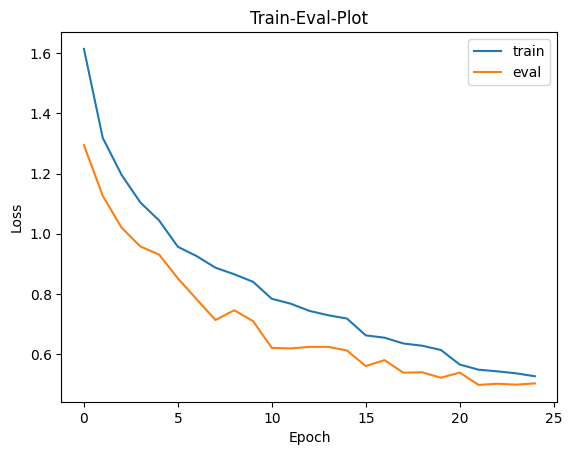

In [5]:
from cfgs.exercise_3 import cnn_cifar10
q3b_p2_config = cnn_cifar10.q3b_p2_dropout_experiment

datamodule_class = q3b_p2_config['datamodule']
data_args = q3b_p2_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q3b_p2_config['trainer_module']
trainer_cnn = trainer_class(
    config = q3b_p2_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list = trainer_cnn.train()


# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q3b_p2/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

transforms for preset CIFAR10 for split train are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 45000 samples with {'batch_size': 200, 'shuffle': True, 'num_workers': 6}
Initialization heldout DataLoader 5000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
transforms for preset CIFAR10 for split eval are Compose(
    ToTensor()
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
)
Files already downloaded and verified
Initialization DataLoader for 10000 samples with {'batch_size': 200, 'shuffle': False, 'num_workers': 6}
Warning! Log file ./Logs\CIFAR10_CNN_q3b_p3.log already exists! The logs will be appended!
Warning! Save dir Saved\CIFAR10_CNN_q3b_p3 already exists!Existing checkpoints will be overwritten!
Number of trainable parameters in each layer: 
 3456
 128
 128
 128
 589824
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 512
 512
 512
 2359296
 51

Train Epoch: 1 Loss: 2.1857: : 100% 45000/45000 [00:47<00:00, 956.52it/s] 
Eval Loss: 2.4110: : 100% 5000/5000 [00:17<00:00, 290.56it/s] 


Saved model on eval based on eval_loss at this step. Previous: inf, Current: 2.436960334777832


Train Epoch: 2 Loss: 2.1922: : 100% 45000/45000 [00:44<00:00, 1022.72it/s]
Eval Loss: 2.4150: : 100% 5000/5000 [00:16<00:00, 296.02it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.436960334777832, Current: 2.436130199432373


Train Epoch: 3 Loss: 2.0924: : 100% 45000/45000 [00:43<00:00, 1026.15it/s]
Eval Loss: 2.4446: : 100% 5000/5000 [00:17<00:00, 289.69it/s] 
Train Epoch: 4 Loss: 2.0941: : 100% 45000/45000 [00:43<00:00, 1025.18it/s]
Eval Loss: 2.4972: : 100% 5000/5000 [00:17<00:00, 293.31it/s] 
Train Epoch: 5 Loss: 2.1254: : 100% 45000/45000 [00:43<00:00, 1024.54it/s]
Eval Loss: 2.4818: : 100% 5000/5000 [00:17<00:00, 293.88it/s] 
Train Epoch: 6 Loss: 2.2014: : 100% 45000/45000 [00:44<00:00, 1019.48it/s]
Eval Loss: 2.4339: : 100% 5000/5000 [00:17<00:00, 290.45it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.436130199432373, Current: 2.424477186203003


Train Epoch: 7 Loss: 2.0284: : 100% 45000/45000 [00:43<00:00, 1025.55it/s]
Eval Loss: 2.4267: : 100% 5000/5000 [00:17<00:00, 289.97it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.424477186203003, Current: 2.4148165130615236


Train Epoch: 8 Loss: 2.0144: : 100% 45000/45000 [00:44<00:00, 1020.96it/s]
Eval Loss: 2.4939: : 100% 5000/5000 [00:17<00:00, 293.98it/s] 
Train Epoch: 9 Loss: 2.0439: : 100% 45000/45000 [00:44<00:00, 1017.38it/s]
Eval Loss: 2.3718: : 100% 5000/5000 [00:17<00:00, 288.19it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.4148165130615236, Current: 2.346947793960571


Train Epoch: 10 Loss: 2.1320: : 100% 45000/45000 [00:44<00:00, 1020.72it/s]
Eval Loss: 2.2600: : 100% 5000/5000 [00:17<00:00, 290.42it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.346947793960571, Current: 2.24623703956604


Train Epoch: 11 Loss: 2.0141: : 100% 45000/45000 [00:44<00:00, 1020.71it/s]
Eval Loss: 2.3040: : 100% 5000/5000 [00:17<00:00, 290.96it/s] 
Train Epoch: 12 Loss: 2.0597: : 100% 45000/45000 [00:44<00:00, 1014.83it/s]
Eval Loss: 2.3154: : 100% 5000/5000 [00:17<00:00, 290.42it/s] 
Train Epoch: 13 Loss: 2.0689: : 100% 45000/45000 [00:43<00:00, 1023.78it/s]
Eval Loss: 2.2618: : 100% 5000/5000 [00:17<00:00, 284.18it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.24623703956604, Current: 2.238807954788208


Train Epoch: 14 Loss: 2.0518: : 100% 45000/45000 [00:44<00:00, 1015.69it/s]
Eval Loss: 2.2671: : 100% 5000/5000 [00:17<00:00, 290.96it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.238807954788208, Current: 2.232142057418823


Train Epoch: 15 Loss: 2.1457: : 100% 45000/45000 [00:44<00:00, 1015.06it/s]
Eval Loss: 2.2719: : 100% 5000/5000 [00:17<00:00, 287.13it/s] 
Train Epoch: 16 Loss: 2.1480: : 100% 45000/45000 [00:43<00:00, 1035.50it/s]
Eval Loss: 2.2910: : 100% 5000/5000 [00:16<00:00, 300.76it/s] 
Train Epoch: 17 Loss: 2.0513: : 100% 45000/45000 [00:43<00:00, 1037.76it/s]
Eval Loss: 2.2535: : 100% 5000/5000 [00:17<00:00, 280.23it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.232142057418823, Current: 2.2248249435424805


Train Epoch: 18 Loss: 2.0684: : 100% 45000/45000 [00:44<00:00, 1021.43it/s]
Eval Loss: 2.2565: : 100% 5000/5000 [00:17<00:00, 289.70it/s] 
Train Epoch: 19 Loss: 2.0737: : 100% 45000/45000 [00:44<00:00, 1020.85it/s]
Eval Loss: 2.3041: : 100% 5000/5000 [00:17<00:00, 286.03it/s] 
Train Epoch: 20 Loss: 2.0785: : 100% 45000/45000 [00:44<00:00, 1007.00it/s]
Eval Loss: 2.2496: : 100% 5000/5000 [00:17<00:00, 289.73it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.2248249435424805, Current: 2.2135692501068114


Train Epoch: 21 Loss: 2.0605: : 100% 45000/45000 [00:44<00:00, 1018.25it/s]
Eval Loss: 2.2791: : 100% 5000/5000 [00:17<00:00, 289.23it/s] 
Train Epoch: 22 Loss: 2.0987: : 100% 45000/45000 [00:44<00:00, 1021.17it/s]
Eval Loss: 2.3041: : 100% 5000/5000 [00:17<00:00, 289.46it/s] 
Train Epoch: 23 Loss: 2.0132: : 100% 45000/45000 [00:44<00:00, 1020.66it/s]
Eval Loss: 2.2592: : 100% 5000/5000 [00:17<00:00, 289.61it/s] 
Train Epoch: 24 Loss: 2.1108: : 100% 45000/45000 [00:44<00:00, 1020.67it/s]
Eval Loss: 2.2353: : 100% 5000/5000 [00:17<00:00, 286.40it/s] 


Saved model on eval based on eval_loss at this step. Previous: 2.2135692501068114, Current: 2.2038525772094726


Train Epoch: 25 Loss: 2.0645: : 100% 45000/45000 [00:44<00:00, 1018.21it/s]
Eval Loss: 2.2680: : 100% 5000/5000 [00:17<00:00, 288.99it/s] 
Eval Loss: 2.2294: : 100% 10000/10000 [00:15<00:00, 646.66it/s]


{'loss': 2.2006626558303832, 'top1': 0.17040000000000002, 'top5': 0.6844999999999999}


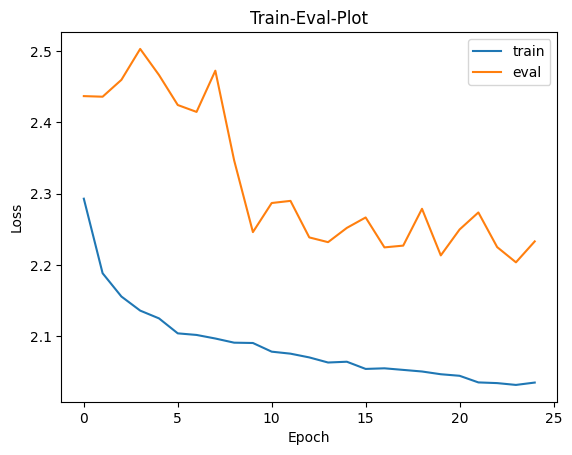

In [ ]:
from cfgs.exercise_3 import cnn_cifar10
q3b_p3_config = cnn_cifar10.q3b_p3_dropout_experiment

datamodule_class = q3b_p3_config['datamodule']
data_args = q3b_p3_config['data_args']

dm = datamodule_class(**data_args)

# Based on the heldout_split in the config file,
# the datamodule will break the dataset into two splits
train_data_loader = dm.get_loader()
valid_data_loader = dm.get_heldout_loader()

# Test loader is the same as train loader
# except that training=False, shuffle=False, and no splitting is done
# So we use the exact config from training and just modify these arguments
test_data_args = deepcopy(data_args) # copy the args
test_data_args['training'] = False
test_data_args['shuffle'] = False
test_data_args['heldout_split'] = 0.0

# Now we initialize the test module with the modified config
test_dm = datamodule_class(**test_data_args)
test_loader = test_dm.get_loader() # and get the loader from it



trainer_class = q3b_p3_config['trainer_module']
trainer_cnn = trainer_class(
    config = q3b_p3_config,
    log_dir = ospj(PROJECT_ROOT,'Logs'),
    train_loader=train_data_loader,
    eval_loader=valid_data_loader,
)

train_loss_list, eval_loss_list = trainer_cnn.train()


# Change this to the experiment you want to evaluate
path = './Saved/CIFAR10_CNN_q3b_p3/best_val_model.pth'
trainer_cnn.load_model(path=path)
result = trainer_cnn.evaluate(loader=test_loader)
print(result)


plt.plot(train_loss_list, label='train')
plt.plot(eval_loss_list, label='eval')
plt.title('Train-Eval-Plot')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Q3.b: According to the results got from dropoutting by probability of 0.1, 0.3, and 0.9, we have seen that the best result is gained by probability of 0.3. It not only provides better results than the model without dropout (improved top1 accuracy of the value of 2), but also it has helped the model to prevent overfitting. (There is not sign of overfitting in as much as we can see during training process of 25 epochs).

<br>
<br>
<br>